In [1]:
%matplotlib inline

In [2]:
import numpy as np
import urllib
import scipy.optimize
import random
from math import exp
from math import log
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

In [3]:
random.seed(0)

def parseData(fname):
  for l in urllib.urlopen(fname):
    yield eval(l)

print "Reading data..."
dataFile = open("../HW1/winequality-white.csv")
header = dataFile.readline()
fields = ["constant"] + header.strip().replace('"','').split(';')
featureNames = fields[:-1]
labelName = fields[-1]
lines = [[1.0] + [float(x) for x in l.split(';')] for l in dataFile]
rawLines = lines[:]
random.shuffle(lines)

X = [l[:-1] for l in lines]
y = [l[-1] > 5 for l in lines]
print "done"

Reading data...
done


In [4]:
X_train = X[:int(len(X)/3)]
y_train = y[:int(len(y)/3)]
X_validate = X[int(len(X)/3):int(2*len(X)/3)]
y_validate = y[int(len(y)/3):int(2*len(y)/3)]
X_test = X[int(2*len(X)/3):]
y_test = y[int(2*len(X)/3):]

In [5]:
def inner(x,y):
  return sum([x[i]*y[i] for i in range(len(x))])

def sigmoid(x):
  return 1.0 / (1 + exp(-x))

##################################################
# Logistic regression by gradient ascent         #
##################################################

# NEGATIVE Log-likelihood
def f(theta, X, y, lam):
  loglikelihood = 0
  for i in range(len(X)):
    logit = inner(X[i], theta)
    loglikelihood -= log(1 + exp(-logit))
    if not y[i]:
      loglikelihood -= logit
  for k in range(len(theta)):
    loglikelihood -= lam * theta[k]*theta[k]
  # for debugging
  # print "ll =", loglikelihood
  return -loglikelihood

# NEGATIVE Derivative of log-likelihood
def fprime(theta, X, y, lam):
  dl = [0]*len(theta)
  for i in range(len(X)):
    logit = inner(X[i], theta)
    for k in range(len(theta)):
      dl[k] += X[i][k] * (1 - sigmoid(logit))
      if not y[i]:
        dl[k] -= X[i][k]
  for k in range(len(theta)):
    dl[k] -= lam*2*theta[k]
  return np.array([-x for x in dl])


##################################################
# Train                                          #
##################################################

def train(lam):
  theta,_,_ = scipy.optimize.fmin_l_bfgs_b(f, [0]*len(X[0]), fprime, pgtol = 10, args = (X_train, y_train, lam))
  return theta

##################################################
# Predict                                        #
##################################################

def performance(theta):
  scores_train = [inner(theta,x) for x in X_train]
  scores_validate = [inner(theta,x) for x in X_validate]
  scores_test = [inner(theta,x) for x in X_test]

  predictions_train = [s > 0 for s in scores_train]
  predictions_validate = [s > 0 for s in scores_validate]
  predictions_test = [s > 0 for s in scores_test]

  correct_train = [(a==b) for (a,b) in zip(predictions_train,y_train)]
  correct_validate = [(a==b) for (a,b) in zip(predictions_validate,y_validate)]
  correct_test = [(a==b) for (a,b) in zip(predictions_test,y_test)]
  
  acc_train = sum(correct_train) * 1.0 / len(correct_train)
  acc_validate = sum(correct_validate) * 1.0 / len(correct_validate)
  acc_test = sum(correct_test) * 1.0 / len(correct_test)
  return acc_train, acc_validate, acc_test

##################################################
# Validation pipeline                            #
##################################################

# Problem 1

In [6]:
for lam in [0, 0.01, 1.0, 100.0]:
  theta = train(lam)
  acc_train, acc_validate, acc_test = performance(theta)
  print("lambda = " + str(lam) + ";\ttrain=" + str(acc_train) + "; validate=" + str(acc_validate) + "; test=" + str(acc_test))

lambda = 0;	train=0.752450980392; validate=0.758726270667; test=0.738518064911
lambda = 0.01;	train=0.748774509804; validate=0.757501530925; test=0.738518064911
lambda = 1.0;	train=0.732230392157; validate=0.756889161053; test=0.731781996326
lambda = 100.0;	train=0.66237745098; validate=0.681567666871; test=0.680342927128


# Problem 2

In [7]:
X = [l[:-1] for l in rawLines]
y = [l[-1] > 5 for l in rawLines]
X_train = X[:int(len(X)/3)]
y_train = y[:int(len(y)/3)]
X_validate = X[int(len(X)/3):int(2*len(X)/3)]
y_validate = y[int(len(y)/3):int(2*len(y)/3)]
X_test = X[int(2*len(X)/3):]
y_test = y[int(2*len(X)/3):]

In [8]:
theta = train(0.01)
scores_test = [inner(theta,x) for x in X_test]
predictions_test = map(lambda s: True if s > 0 else False, scores_test)

In [9]:
print "Total:", len(y_test)
truePositives = len(filter(lambda x: x[0] == x[1] == True, zip(predictions_test, y_test)))
trueNegatives = len(filter(lambda x: x[0] == x[1] == False, zip(predictions_test, y_test)))
falsePositives = len(filter(lambda x: x[0] == True and x[1] == False, zip(predictions_test, y_test)))
falseNegatives = len(filter(lambda x: x[0] == False and x[1] == True, zip(predictions_test, y_test)))
truePositiveRate = truePositives * 1. / (truePositives + falseNegatives)
trueNegativeRate = trueNegatives * 1. / (trueNegatives + falsePositives)
balanceErrorRate = 1 - 0.5 * (truePositiveRate + trueNegativeRate)
print "True Positives:", truePositives
print "True Negatives:", trueNegatives
print "False Positives:", falsePositives
print "False Negatives:", falseNegatives
print "Balanced Error Rate:", balanceErrorRate

Total: 1633
True Positives: 1129
True Negatives: 145
False Positives: 321
False Negatives: 38
Balanced Error Rate: 0.360701663412


# Problem 3

In [10]:
scoreData = zip(scores_test, y_test)
scoreData.sort(key = lambda x:x[0], reverse = True)

In [11]:
def calculatePrecisionAndRecall(scoreData, i):
    retrievedData = scoreData[:i]
    precision = len(filter(lambda x: x[0] > 0 and x[1] > 0, retrievedData)) * 1.0 / i
    recall = len(filter(lambda x: x[0] > 0 and x[1] > 0, retrievedData)) * 1.0 / sum(y_test)
    return precision, recall

In [12]:
for i in [10, 500, 1000]:
    precision, recall = calculatePrecisionAndRecall(scoreData, i)
    print "Retrieve", i,"data, precision is", precision, ", recall is", recall

Retrieve 10 data, precision is 1.0 , recall is 0.00856898029135
Retrieve 500 data, precision is 0.956 , recall is 0.409597257926
Retrieve 1000 data, precision is 0.864 , recall is 0.740359897172


# Problem 4

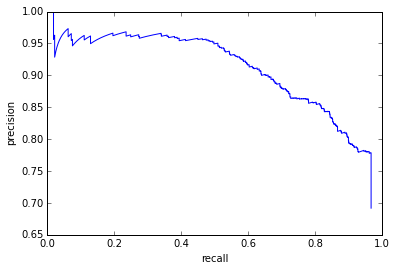

In [14]:
precisionPath = []
recallPath = []
for i in xrange(1, len(y_test)):
    precision, recall = calculatePrecisionAndRecall(scoreData, i)
    precisionPath.append(precision)
    recallPath.append(recall)
plt.plot(recallPath, precisionPath)
plt.xlabel("recall")
plt.ylabel("precision")

# Problem 5

In [17]:
np.sum(np.var(X_train, axis=0) * len(X_train))

3675818.6168781249

# Problem 6

In [33]:
pca = PCA(n_components = 11)
pca.fit(map(lambda line: line[1:], X_train))
pca.components_

array([[  3.23636346e-04,  -1.42201752e-04,  -3.17030713e-04,
         -5.36390435e-02,  -9.30284526e-05,  -2.54030965e-01,
         -9.65655009e-01,  -3.19990241e-05,   2.95831396e-04,
         -3.84043646e-04,   1.00526693e-02],
       [ -7.57985623e-03,  -1.66366340e-03,   1.04742899e-03,
          5.21677266e-02,   4.49425600e-05,   9.65020304e-01,
         -2.56793964e-01,   7.90089050e-06,   5.24900596e-04,
         -1.09699394e-03,  -2.89827657e-03],
       [  1.82124420e-02,   2.54680710e-03,   3.31838657e-03,
          9.93221259e-01,  -1.51888372e-04,  -6.42297821e-02,
         -3.91682592e-02,   4.30929482e-04,  -6.93199060e-03,
         -2.85216045e-03,  -8.62920933e-02],
       [ -1.56811999e-01,  -3.28220652e-03,  -1.66866136e-02,
         -8.28549640e-02,   6.91822288e-03,  -1.13029682e-03,
         -5.39110108e-03,   9.49080503e-04,  -2.68027305e-03,
         -1.30498102e-03,  -9.83955205e-01],
       [ -9.81360642e-01,   1.45890108e-02,  -5.92643662e-02,
          3.17

# Problem 7

In [42]:
print np.sum(pca.explained_variance_[4:])*len(X_train)

1345.4755741


# Problem 8

In [39]:
trainMSEPath = []
testMSEPath = []
for i in range(1, 12):
    pca = PCA(n_components = i)
    pcaTrain = pca.fit_transform([line[1:] for line in X_train])
    theta_pca, residuals_pca = np.linalg.lstsq([[1] + line for line in pcaTrain], y_train)[:2]
    testMSEPath.append(mean_squared_error(
            np.dot([[1] + line for line in pca.transform([line[1:] for line in X_test])],
                    theta_pca), y_test))
    trainMSEPath.append(residuals_pca * 1.0 / len(X_train))

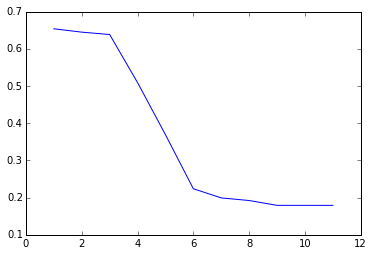

In [40]:
plt.plot([i for i in range(1,12)], trainMSEPath)

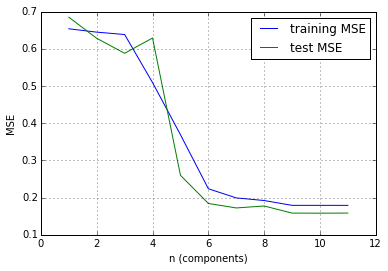

In [41]:
trainMSE, = plt.plot([i for i in range(1,12)], trainMSEPath)
testMSE, = plt.plot([i for i in range(1,12)], testMSEPath)
plt.xlabel('n (components)')
plt.ylabel("MSE")
plt.legend([trainMSE, testMSE], ["training MSE", "test MSE"])
plt.grid(True)